In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load and prepare data
data = pd.read_csv('Datasets/mall.csv')
X = data[['Age', 'Annual Income (k$)']]
y = data['Spending Score (1-100)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Base Model Performance

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from time import time

# Baseline model (updated to remove warning)
def create_baseline_model():
    model = Sequential([
        Input(shape=(2,)),  # Explicit Input layer instead of input_shape in Dense
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and evaluate
start_time = time()
baseline_model = create_baseline_model()
history = baseline_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                           validation_split=0.2, verbose=0)
training_time = time() - start_time

# Evaluate
baseline_loss, baseline_mae = baseline_model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Training time: {training_time:.2f} seconds")
print(f"Test MAE: {baseline_mae:.2f}")
print(f"Test MSE: {baseline_loss:.2f}")

Training time: 7.91 seconds
Test MAE: 16.54
Test MSE: 415.56


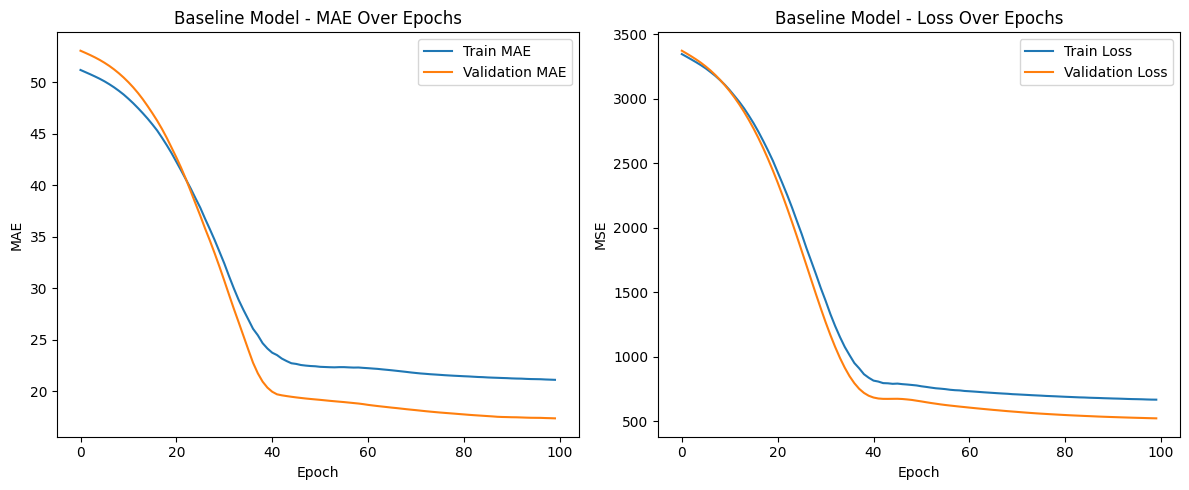

In [13]:
import matplotlib.pyplot as plt

# Plot training history for baseline model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Baseline Model - MAE Over Epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model - Loss Over Epochs')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

### Hyperparameter Tuning Approach

In [9]:
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow import keras
from time import time

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))  # Explicit input layer
    
    # Tune number of layers (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'act_{i}', ['relu', 'tanh', 'elu'])))  # Added 'elu' as option
            
    model.add(Dense(1))
    
    # Tune learning rate with more granular options
    lr = hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')
    
    # Tune optimizer choice
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    model.compile(
        optimizer=keras.optimizers.get({
            'class_name': optimizer,
            'config': {'learning_rate': lr}
        }),
        loss='mse',
        metrics=['mae'])
    return model

# Initialize tuner with more robust configuration
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,  # Increased from 20 for better exploration
    executions_per_trial=2,
    directory='tuning',
    project_name='spending_score',
    overwrite=True)  # Allows overwriting previous runs

# Add early stopping to the search
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run tuning
print("Starting hyperparameter search...")
start_tune_time = time()
tuner.search(
    X_train_scaled, 
    y_train,
    epochs=100,  # Increased epochs since we have early stopping
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1)  # Set to 1 to see progress
tuning_time = time() - start_tune_time

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Number of layers: {best_hps.get('num_layers')}
- Units per layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Activations: {[best_hps.get(f'act_{i}') for i in range(best_hps.get('num_layers'))]}
- Learning rate: {best_hps.get('lr'):.6f}
- Optimizer: {best_hps.get('optimizer')}
""")

best_model = tuner.hypermodel.build(best_hps)

Trial 10 Complete [00h 00m 17s]
val_mae: 37.81476020812988

Best val_mae So Far: 15.78589677810669
Total elapsed time: 00h 02m 50s

Best hyperparameters:
- Number of layers: 3
- Units per layer: [64, 192, 32]
- Activations: ['elu', 'tanh', 'relu']
- Learning rate: 0.002357
- Optimizer: adam



### Optimized Model Performance

In [10]:
# Train best model
start_time = time()
history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=0)
optimized_time = time() - start_time

# Evaluate
optimized_loss, optimized_mae = best_model.evaluate(X_test_scaled, y_test, verbose=0)

### Balanced Optimization

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)
best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
              validation_split=0.2, callbacks=[early_stop], verbose=0)

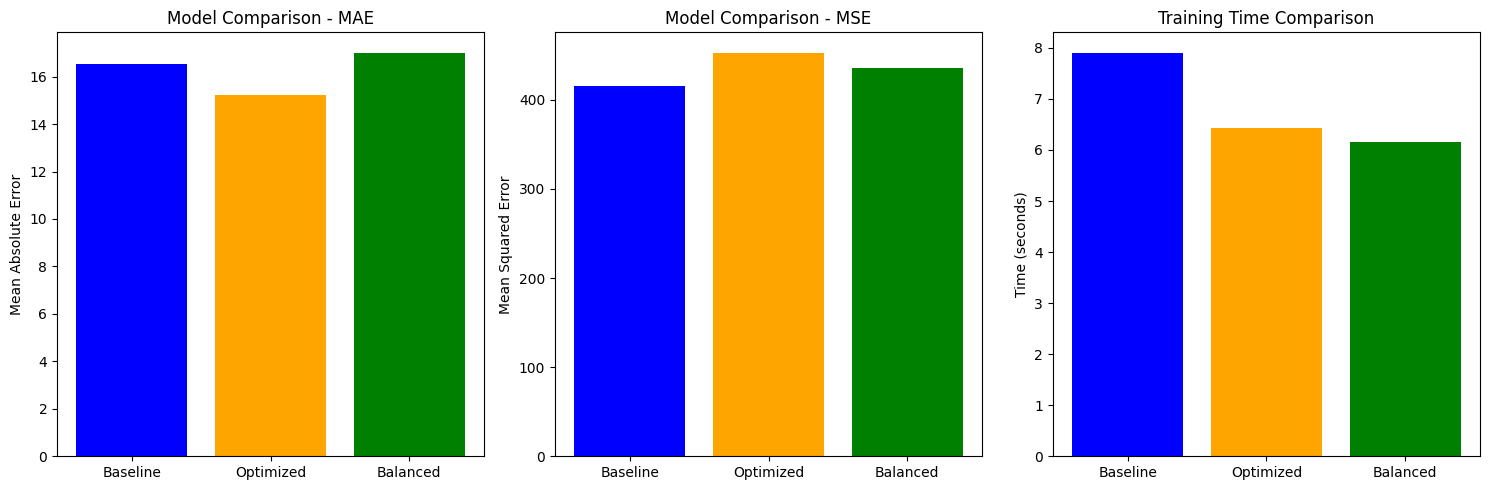

In [14]:
# Model comparison bar chart
models = ['Baseline', 'Optimized', 'Balanced']
mae_scores = [baseline_mae, optimized_mae, balanced_mae]
mse_scores = [baseline_loss, optimized_loss, balanced_loss]
times = [training_time, optimized_time, balanced_time]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(models, mae_scores, color=['blue', 'orange', 'green'])
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 3, 2)
plt.bar(models, mse_scores, color=['blue', 'orange', 'green'])
plt.title('Model Comparison - MSE')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.bar(models, times, color=['blue', 'orange', 'green'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [ ]:
# Train best model
start_time = time()
history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=0)
optimized_time = time() - start_time

# Evaluate
optimized_loss, optimized_mae = best_model.evaluate(X_test_scaled, y_test, verbose=0)

### Final Implementation with Balanced Approach

In [12]:
def create_balanced_model():
    model = Sequential([
        Dense(96, activation='relu', input_shape=(2,)),
        Dense(48, activation='relu'),
        Dense(1)
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# With early stopping
balanced_model = create_balanced_model()
start_time = time()
history = balanced_model.fit(X_train_scaled, y_train, epochs=100, batch_size=64,
                           validation_split=0.2, callbacks=[early_stop], verbose=0)
balanced_time = time() - start_time

balanced_loss, balanced_mae = balanced_model.evaluate(X_test_scaled, y_test, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020A944EF600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


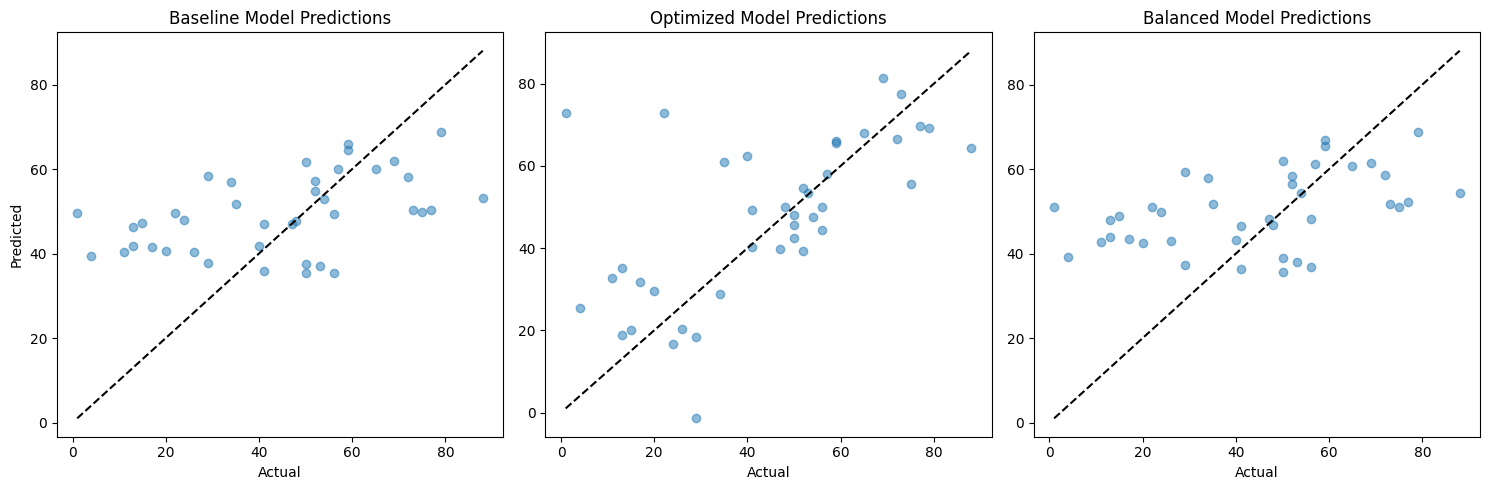

In [15]:
# Generate predictions
baseline_pred = baseline_model.predict(X_test_scaled).flatten()
optimized_pred = best_model.predict(X_test_scaled).flatten()
balanced_pred = balanced_model.predict(X_test_scaled).flatten()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, baseline_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Baseline Model Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 3, 2)
plt.scatter(y_test, optimized_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Optimized Model Predictions')
plt.xlabel('Actual')

plt.subplot(1, 3, 3)
plt.scatter(y_test, balanced_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Balanced Model Predictions')
plt.xlabel('Actual')

plt.tight_layout()
plt.show()

In [19]:
# For Baseline Model
start_time = time()
baseline_model = create_baseline_model()
baseline_history = baseline_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                                   validation_split=0.2, verbose=0)
training_time = time() - start_time

# For Optimized Model
start_time = time()
optimized_history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                                 validation_split=0.2, callbacks=[early_stop], verbose=0)
optimized_time = time() - start_time

# For Balanced Model
balanced_model = create_balanced_model()
start_time = time()
balanced_history = balanced_model.fit(X_train_scaled, y_train, epochs=100, batch_size=64,
                                   validation_split=0.2, callbacks=[early_stop], verbose=0)
balanced_time = time() - start_time

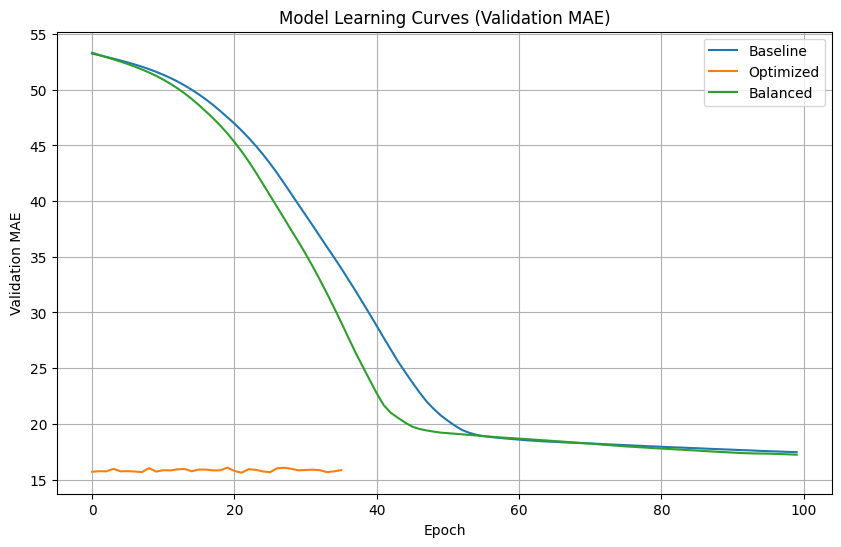

In [20]:
# Get history for all models (need to rerun fits with history capture)
plt.figure(figsize=(10, 6))
plt.plot(baseline_history.history['val_mae'], label='Baseline')
plt.plot(optimized_history.history['val_mae'], label='Optimized')
plt.plot(balanced_history.history['val_mae'], label='Balanced')
plt.title('Model Learning Curves (Validation MAE)')
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()